### Task 2 – Bayesian Change Point Detection on Brent Crude Oil Prices (2012–2022 focus)
**Objective**  
Identify structural breaks (mean shifts) using a single change-point Bayesian model in PyMC, quantify impacts, and associate detected breaks with major geopolitical/OPEC events.

In [5]:
# eda.ipynb – Exploratory Data Analysis (Improved – Full Task 1 & 2 Preparation)

import sys
from pathlib import Path
sys.path.append(str(Path().cwd().parent))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

from src.data_loader import BrentDataLoader
from src.data_preprocessor import BrentDataPreprocessor

%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

In [6]:
print("Loading Brent oil price data...")
loader = BrentDataLoader()
df_raw = loader.load()
prep = BrentDataPreprocessor(df_raw)

df_full = prep.add_features(focus_period=None)     # Full history
df_focus = prep.get_processed(focus_period='2012-01-01')  # Recent focus

print(f"Full dataset: {df_full.index.min():%Y-%m-%d} → {df_full.index.max():%Y-%m-%d} ({len(df_full):,} obs)")
print(f"Focus period: {df_focus.index.min():%Y-%m-%d} → {df_focus.index.max():%Y-%m-%d} ({len(df_focus):,} obs)")

Loading Brent oil price data...
Raw data loaded: 9011 rows, 2 columns
Data loaded successfully: 1987-05-20 to 2022-11-14
Total observations: 9011
Subset to >= 2012-01-01: 2760 observations remain
Full dataset: 1987-05-20 → 2022-11-14 (9,011 obs)
Focus period: 2012-01-03 → 2022-11-14 (2,760 obs)


In [7]:
# Define the event table (minimum 10–15 events, consistent schema)
events_data = [
    {"Date": "1990-08-02", "Event Description": "Iraqi invasion of Kuwait", "Category": "Geopolitical conflict"},
    {"Date": "2008-07-11", "Event Description": "Global Financial Crisis peak", "Category": "Economic shock"},
    {"Date": "2011-02-15", "Event Description": "Arab Spring / Libyan civil war", "Category": "Geopolitical unrest"},
    {"Date": "2014-11-27", "Event Description": "OPEC decides not to cut production (shale glut)", "Category": "OPEC policy"},
    {"Date": "2016-11-30", "Event Description": "OPEC agrees first production cut in 8 years", "Category": "OPEC policy"},
    {"Date": "2018-05-08", "Event Description": "US withdraws from Iran JCPOA, reimposes sanctions", "Category": "Sanctions"},
    {"Date": "2019-09-14", "Event Description": "Drone attacks on Saudi Aramco facilities", "Category": "Geopolitical attack"},
    {"Date": "2020-03-09", "Event Description": "OPEC+ talks collapse + COVID demand shock", "Category": "OPEC+/Pandemic"},
    {"Date": "2020-04-12", "Event Description": "Record OPEC+ 9.7M bpd cuts agreed", "Category": "OPEC+ policy"},
    {"Date": "2022-02-24", "Event Description": "Russia invades Ukraine + Western sanctions", "Category": "Geopolitical conflict"},
    # Add 2–5 more if desired
]

events_df = pd.DataFrame(events_data)
events_df['Date'] = pd.to_datetime(events_df['Date'])

# Export to data/ folder (creates folder if missing)
data_dir = Path().cwd().parent / "data"
data_dir.mkdir(exist_ok=True)
events_path = data_dir / "events.csv"
events_df.to_csv(events_path, index=False)

print(f"Events table exported successfully: {events_path.resolve()}")
print(f"Total events: {len(events_df)}")
display(events_df.head(10))

Events table exported successfully: /home/hp/Desktop/10Academy/week11-brent-oil-analysis/data/events.csv
Total events: 10


,Date,Event Description,Category
0,1990-08-02,Iraqi invasion of Kuwait,Geopolitical conflict
1,2008-07-11,Global Financial Crisis peak,Economic shock
2,2011-02-15,Arab Spring / Libyan civil war,Geopolitical unrest
3,2014-11-27,OPEC decides not to cut production (shale glut),OPEC policy
4,2016-11-30,OPEC agrees first production cut in 8 years,OPEC policy
5,2018-05-08,"US withdraws from Iran JCPOA, reimposes sanctions",Sanctions
6,2019-09-14,Drone attacks on Saudi Aramco facilities,Geopolitical attack
7,2020-03-09,OPEC+ talks collapse + COVID demand shock,OPEC+/Pandemic
8,2020-04-12,Record OPEC+ 9.7M bpd cuts agreed,OPEC+ policy
9,2022-02-24,Russia invades Ukraine + Western sanctions,Geopolitical conflict


In [8]:
def adf_report(series, title):
    res = adfuller(series.dropna(), autolag='AIC')
    print(f"\n{title}")
    print(f"  ADF statistic    : {res[0]:.4f}")
    print(f"  p-value          : {res[1]:.6f}")
    print(f"  Stationary?      : {'YES' if res[1] < 0.05 else 'NO'}")
    print(f"  Critical values  : {res[4]}")

adf_report(df_focus['Price'],      "Raw prices (non-stationary expected)")
adf_report(df_focus['log_price'],  "Log prices")
adf_report(df_focus['log_return'], "Log returns (stationary expected)")

print("\nInterpretation:")
print("Raw and log prices show unit root (p > 0.05) → non-stationary due to trends/regime shifts.")
print("Log returns are clearly stationary (p << 0.05) → differencing removes trend.")
print("→ Supports modeling price levels directly to detect mean-regime changes (change point model).")


Raw prices (non-stationary expected)
  ADF statistic    : -2.2076
  p-value          : 0.203484
  Stationary?      : NO
  Critical values  : {'1%': np.float64(-3.4327458473129906), '5%': np.float64(-2.86259851213211), '10%': np.float64(-2.5673334803017864)}

Log prices
  ADF statistic    : -2.6647
  p-value          : 0.080347
  Stationary?      : NO
  Critical values  : {'1%': np.float64(-3.4327432168541914), '5%': np.float64(-2.862597350432621), '10%': np.float64(-2.5673328618123117)}

Log returns (stationary expected)
  ADF statistic    : -8.9710
  p-value          : 0.000000
  Stationary?      : YES
  Critical values  : {'1%': np.float64(-3.4327423413176983), '5%': np.float64(-2.862596963765895), '10%': np.float64(-2.5673326559507625)}

Interpretation:
Raw and log prices show unit root (p > 0.05) → non-stationary due to trends/regime shifts.
Log returns are clearly stationary (p << 0.05) → differencing removes trend.
→ Supports modeling price levels directly to detect mean-regime 

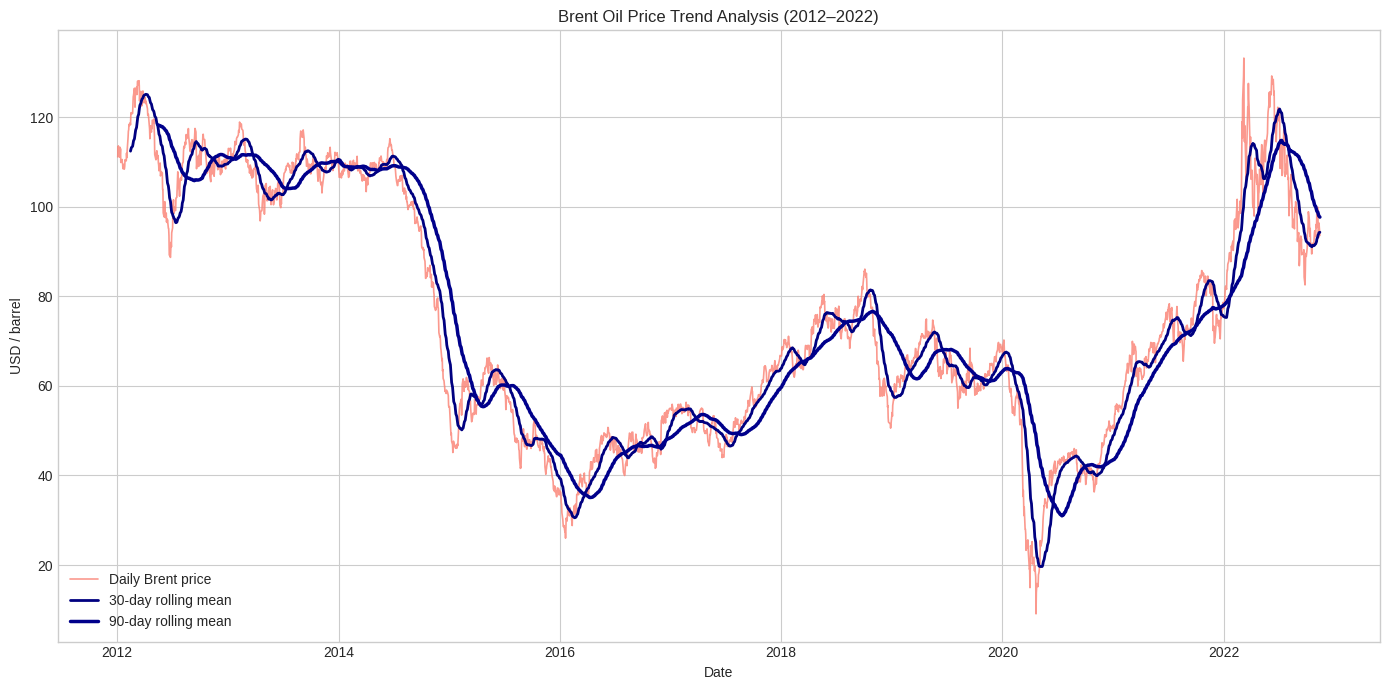

Insight: Rolling means reveal three clear regimes:
  • 2012–mid 2014: high plateau (~$100–120)
  • 2015–2019: lower regime (~$40–80)
  • 2020–2022: extreme volatility with rapid shifts
→ Strong visual evidence of abrupt structural breaks → justifies change point modeling.


In [9]:
plt.figure(figsize=(14, 7))

plt.plot(df_focus.index, df_focus['Price'], color='salmon', lw=1.2, alpha=0.8, label='Daily Brent price')
plt.plot(df_focus.index, df_focus['Price'].rolling(30).mean(), color='navy', lw=2, label='30-day rolling mean')
plt.plot(df_focus.index, df_focus['Price'].rolling(90).mean(), color='darkblue', lw=2.5, label='90-day rolling mean')

plt.title('Brent Oil Price Trend Analysis (2012–2022)')
plt.ylabel('USD / barrel')
plt.xlabel('Date')
plt.legend()
plt.tight_layout()
plt.show()

print("Insight: Rolling means reveal three clear regimes:")
print("  • 2012–mid 2014: high plateau (~$100–120)")
print("  • 2015–2019: lower regime (~$40–80)")
print("  • 2020–2022: extreme volatility with rapid shifts")
print("→ Strong visual evidence of abrupt structural breaks → justifies change point modeling.")

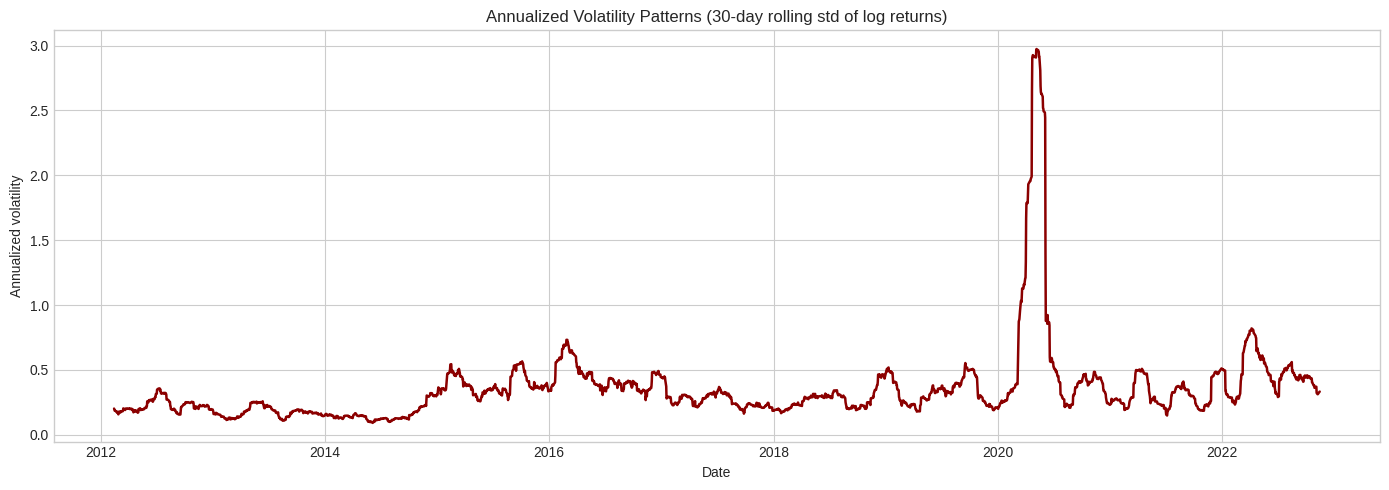

Insight: Volatility is low and stable most of the time, but shows extreme spikes:
  • Gradual rise 2014–2016 (glut uncertainty)
  • Massive peak >2.8 in spring 2020 (COVID + OPEC+ price war)
  • Secondary rise in 2022 (Ukraine conflict)
→ Volatility is event-driven → future model extensions could allow regime-specific variance.


In [10]:
vol = df_focus['log_return'].rolling(30).std() * np.sqrt(252)  # annualized
vol = vol.dropna()

plt.figure(figsize=(14, 5))
plt.plot(df_focus.index[-len(vol):], vol, color='darkred', lw=1.8)
plt.title('Annualized Volatility Patterns (30-day rolling std of log returns)')
plt.ylabel('Annualized volatility')
plt.xlabel('Date')
plt.tight_layout()
plt.show()

print("Insight: Volatility is low and stable most of the time, but shows extreme spikes:")
print("  • Gradual rise 2014–2016 (glut uncertainty)")
print("  • Massive peak >2.8 in spring 2020 (COVID + OPEC+ price war)")
print("  • Secondary rise in 2022 (Ukraine conflict)")
print("→ Volatility is event-driven → future model extensions could allow regime-specific variance.")

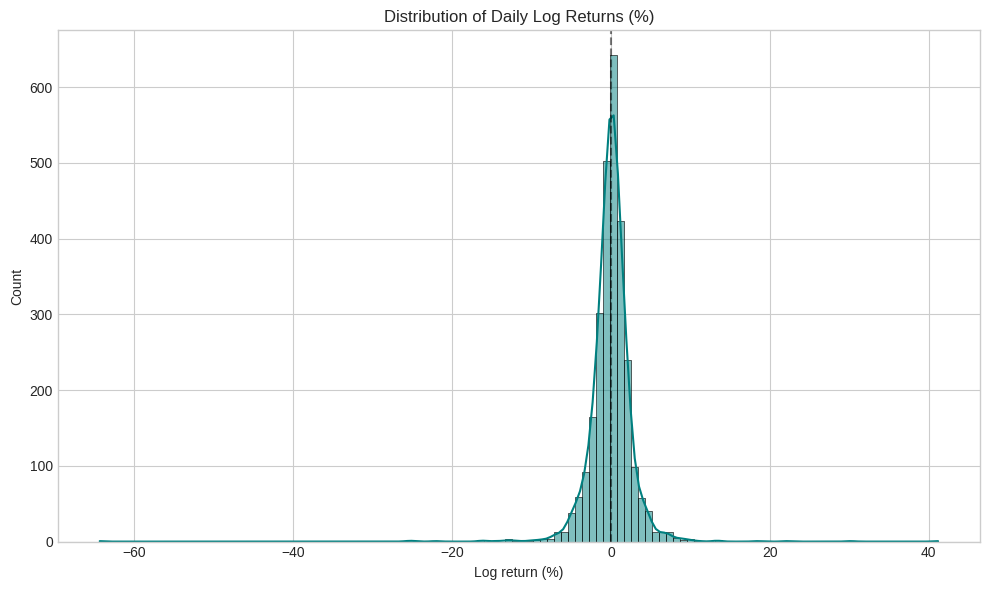

Insight: Distribution is roughly symmetric around 0 but shows very fat tails:
  • Most returns small (±5%)
  • Extreme outliers (down to –64%, up to +40%) during crises
→ Typical financial return behavior under shocks → supports Bayesian uncertainty quantification.


In [11]:
plt.figure(figsize=(10, 6))
sns.histplot(df_focus['log_return'].dropna() * 100, bins=120, kde=True, color='teal', stat='count')
plt.title('Distribution of Daily Log Returns (%)')
plt.xlabel('Log return (%)')
plt.ylabel('Count')
plt.axvline(0, color='black', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

print("Insight: Distribution is roughly symmetric around 0 but shows very fat tails:")
print("  • Most returns small (±5%)")
print("  • Extreme outliers (down to –64%, up to +40%) during crises")
print("→ Typical financial return behavior under shocks → supports Bayesian uncertainty quantification.")

In [12]:
print("""
Task 1 & 2 Takeaways:

1. Clear regime shifts visible in price + rolling means → model price levels for mean changes.
2. Non-stationary prices / stationary returns → confirms change point on levels is appropriate.
3. Event-driven volatility clustering → core model uses shared σ; volatility shown in dashboard.
4. Strong visual alignment with events.csv → high potential for meaningful post-model association.

→ Proceed to Bayesian change point modeling on price series (single + recursive).
""")


Task 1 & 2 Takeaways:

1. Clear regime shifts visible in price + rolling means → model price levels for mean changes.
2. Non-stationary prices / stationary returns → confirms change point on levels is appropriate.
3. Event-driven volatility clustering → core model uses shared σ; volatility shown in dashboard.
4. Strong visual alignment with events.csv → high potential for meaningful post-model association.

→ Proceed to Bayesian change point modeling on price series (single + recursive).

